# BiciMAD en El Retiro
## 1. Carga y limpieza de datos


### Motivación
Comenzamos el estudio de los datos de BiciMAD con el objetivo último de conocer mejor la actividad de los usuarios de este servicio que transitan por el interior del parque.<br>
En este notebook cargaremos datos <a href='http://opendata.emtmadrid.es/Datos-estaticos/Datos-generales-(1)'>proporcionados por la EMT</a>, gestora del servicio, y los prepararemos para el procesado posterior.<br><br>
Nos centraremos en la actividad del mes de **agosto de 2018**, con datos que comprenden casi **275.000** trayectos efectuados en ese mes en Madrid. Tras haber revisado datos de todos los meses, y habiéndolo confirmado con la EMT, debido a problemas técnicos más de la mitad de los datos del año 2017-2018 carecen de track GPS que permita conocer la ubicación de los mismos. Otro meses contienen pocos tracks GPS debido a averías en muchas bicicletas. <br>A partir de verano de 2018 la situación mejora y, en agosto, más del 80% de los trayectos incluyen track.

⌛ _Se puede lanzar todo el notebook de una vez: tiempo estimado de ejecución 4 minutos_

### Librerías
Es necesario instalar e importar las librerías siguientes: 

In [1]:
import numpy as np
import pandas as pd

#Reconstrucción de la zona horaria en formato ISO-8601
#!pip install iso8601
import iso8601

#Dump de dict a (geo)json
import json

#Visualización
import matplotlib.pyplot as plt 
%matplotlib inline

### Importación del fichero

El fichero comprimido **201808_Usage_Bicimad.zip** se encuentra en la carpeta data y también puede descargarse del enlace proporcionado antes. <br>En su interior contiene un fichero JSON con un trayecto por línea.

In [2]:
# /!\ Wall time: 25 s
rides = pd.read_json('data/201808_Usage_Bicimad.zip', lines=True)

En la página de la EMT encontramos <a href="http://opendata.emtmadrid.es/Documentos/Servicios-y-estructuras-Bicimad-V1-1.aspx">la estructura y explicación funcional</a> de los campos contenidos.

In [3]:
rides.head(3)

,_id,ageRange,idplug_base,idplug_station,idunplug_base,idunplug_station,track,travel_time,unplug_hourTime,user_day_code,user_type,zip_code
0,{'$oid': '5b6779012f384302541d6813'},0,11,43,7,1,"{'type': 'FeatureCollection', 'features': [{'g...",228,{'$date': '2018-08-01T01:00:00.000+0200'},6c30d6e283ea7a160379fa9adb20b93d2c06e16853ad08...,1,
1,{'$oid': '5b6779012f384302541d6814'},0,22,11,11,163,"{'type': 'FeatureCollection', 'features': [{'g...",378,{'$date': '2018-08-01T01:00:00.000+0200'},88de7f2b4cb6d46c31cd610e3366f0a099b78f6edf1330...,1,
2,{'$oid': '5b6779012f384302541d6819'},0,14,80,2,46,"{'type': 'FeatureCollection', 'features': [{'g...",380,{'$date': '2018-08-01T01:00:00.000+0200'},2b98916eebc487417337892097e5fd62157e5ff30f36ec...,1,


Comenzamos a adaptar los datos.

### Tratamiento de datos

###### Fecha y hora

In [4]:
#Limpieza del campo fecha/hora, contenida en un diccionario superfluo bajo la clave $date
# /!\ Wall time: 1min 2s
rides['unplug_hourTime'] = rides['unplug_hourTime'].apply(pd.Series)['$date']
rides['unplug_hourTime'].head(1)

0    2018-08-01T01:00:00.000+0200
Name: unplug_hourTime, dtype: object

In [5]:
#Convertimos a formato fecha gestionando previamente el huso horario en formato ISO-8601
rides['unplug_hourTime'] = pd.to_datetime(rides['unplug_hourTime'].apply(iso8601.parse_date))

Con la fecha bien formateada vamos a revisar el estado de los trayectos con o sin GPS este mes.

In [6]:
#Numero de trayectos del mes
len(rides)

274122

###### Existencia de track

In [7]:
#Número de trayectos con información GPS
rides['track'].count()

224536

In [8]:
#Agrupación por día
rides2 = rides[['track','unplug_hourTime']].groupby(pd.DatetimeIndex(rides['unplug_hourTime']).normalize()).count().copy()

In [9]:
rides2['con_track'] = rides2['track'] / rides2['unplug_hourTime']
rides2

,track,unplug_hourTime,con_track
unplug_hourTime,,,
2018-08-01 00:00:00+02:00,10470,12843,0.815230
2018-08-02 00:00:00+02:00,10236,12743,0.803265
2018-08-03 00:00:00+02:00,8929,10936,0.816478
2018-08-04 00:00:00+02:00,5962,7195,0.828631
2018-08-05 00:00:00+02:00,5744,7027,0.817419
2018-08-06 00:00:00+02:00,8253,10003,0.825052
2018-08-07 00:00:00+02:00,9014,11046,0.816042
2018-08-08 00:00:00+02:00,9180,11144,0.823762
2018-08-09 00:00:00+02:00,9105,11148,0.816738


Esto nos indica que el **82%** de los trayectos de agosto tienen track GPS, muy constante todos los días, lo cuál está bastante bien. Dado que la ausencia de GPS es algo aleatorio, independientemente de una zona o estación en concreto, en los conteos posteriores que hagamos podríamos aplicar un factor **1.22x** para aproximar lo que sería el número real de trayectos que han pasado por el parque.

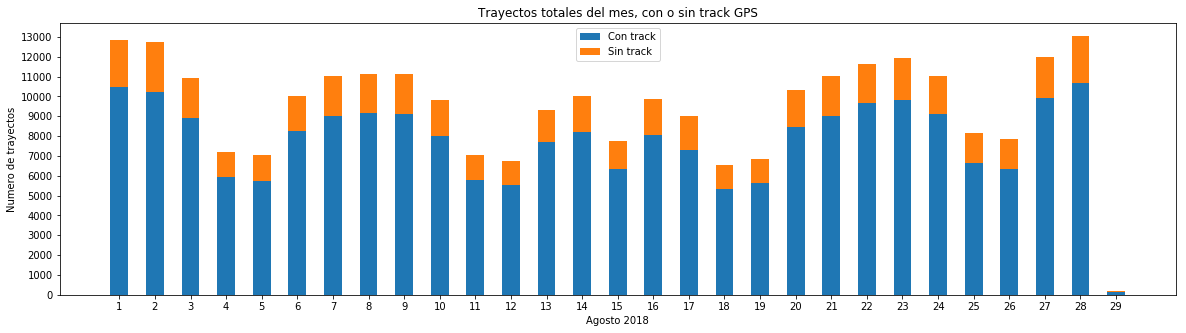

<Figure size 5760x7200 with 0 Axes>

In [10]:
N = len(rides2.index)
withTrack = rides2['track'] #Rides con GPS
noTrack = (rides2['unplug_hourTime']-rides2['track']) #Rides sin GPS
ind = np.arange(N)  
width = 0.5       

plt.figure(figsize=(20,5))
p1 = plt.bar(ind, withTrack, width)
p2 = plt.bar(ind, noTrack, width, bottom=withTrack)

plt.ylabel('Numero de trayectos')
plt.xlabel('Agosto 2018')
plt.title('Trayectos totales del mes, con o sin track GPS')
plt.xticks(ind, rides2.index.day)
plt.yticks(np.arange(0, 14000, 1000))
plt.legend((p1[0], p2[0]), ('Con track', 'Sin track'))
plt.figure(figsize=(80,100))

plt.show()

In [11]:
rides.tail(4)

,_id,ageRange,idplug_base,idplug_station,idunplug_base,idunplug_station,track,travel_time,unplug_hourTime,user_day_code,user_type,zip_code
274118,{'$oid': '5b8c62cb2f38432c70d0921b'},6,9,140,27,95,"{'type': 'FeatureCollection', 'features': [{'g...",738,2018-08-29 00:00:00+02:00,a02b82e667da1fb85b73a29a05ddceada1b5dab16172d6...,1,28039
274119,{'$oid': '5b8c62cb2f38432c70d0921c'},4,30,95,22,172,"{'type': 'FeatureCollection', 'features': [{'g...",868,2018-08-29 00:00:00+02:00,52d96c4f5f152b0bee0794f2511e9dd9bd377022af1fad...,1,28001
274120,{'$oid': '5b8c62cb2f38432c70d0921d'},2,1,136,1,46,NaN,990,2018-08-29 00:00:00+02:00,adf9662785e341aa1aff172dcf1ee2c91f761a51497720...,1,28005
274121,{'$oid': '5b8c62cb2f38432c70d0921e'},0,13,132,3,114,"{'type': 'FeatureCollection', 'features': [{'g...",1005,2018-08-29 00:00:00+02:00,1c873fa1b5f2253566faa1d54299cf4af00b6dfb3ebd4e...,1,


Viendo el gráfico y las últimas líneas, parece que el mes no está completo, tendremos 4 semanas exactas, del **1 al 28** de agosto. En el resto de meses esta ausencia de los últimos días también ocurre, podría ser debido a alguna restricción técnica en la generación de los datos.

In [12]:
#Hay tipos que aún se pueden mejorar
rides.dtypes

_id                                 object
ageRange                             int64
idplug_base                          int64
idplug_station                       int64
idunplug_base                        int64
idunplug_station                     int64
track                               object
travel_time                          int64
unplug_hourTime     datetime64[ns, +02:00]
user_day_code                       object
user_type                            int64
zip_code                            object
dtype: object

###### ID del trayecto

In [13]:
#Limpieza del campo _id, contenido en un diccionario superfluo bajo la clave $oid

# /!\ Wall time: 1min 2s
rides['_id'] = rides['_id'].apply(pd.Series)['$oid']
rides['_id'].head(1)

0    5b6779012f384302541d6813
Name: _id, dtype: object

In [14]:
rides['_id'].head(1)

0    5b6779012f384302541d6813
Name: _id, dtype: object

###### Código postal

In [15]:
#Trim de los espacios
rides['zip_code']=rides.zip_code.str.strip()

In [16]:
#Validación de códigos postales españoles (cinco dígitos entre 01000 y 52999). Estos son los vacíos o inválidos.
rides[-rides.zip_code.str.contains('^(?:0[1-9]|[1-4]\d|5[0-2])\d{3}$')]['zip_code'].value_counts()

                         133679
CODIGO_POSTAL_NOT_DEF        57
2008                         26
maxima87uk                   21
000000                       20
280151                       13
69003                        11
28099912                      9
28                            8
2803                          7
62973                         7
286911                        7
2845                          3
00000                         2
58004                         2
2007                          1
00188                         1
75007                         1
daver                         1
646441026                     1
6301                          1
90007                         1
Name: zip_code, dtype: int64

In [17]:
#Reemplazar vacíos e inválidos por NaN, para tenerlos identificados
rides['zip_code'].replace('^(?!^(?:0[1-9]|[1-4]\d|5[0-2])\d{3}$).*', np.nan, regex=True, inplace=True)

In [18]:
#Sólo hay 39 códigos postales aparentemente válidos (no necesariamente existen) con un único trayecto
len(rides[-rides['zip_code'].duplicated(keep=False)])

39

In [19]:
#Todos los códigos postales que quedan formalmente válidos
rides['zip_code'].value_counts()

28005    13809
28012    13679
28004    11686
28007    11486
28045     8679
28015     8348
28009     8014
28010     6359
28003     5950
28008     4431
28006     4347
28014     4137
28001     3984
28020     3773
28028     3743
28013     3556
28002     2340
28039     1920
28016     1240
28011     1066
28030     1004
28019      765
28036      650
28046      470
28022      468
28026      464
28027      441
28038      429
28053      411
28017      405
         ...  
48960        1
26002        1
32002        1
33005        1
28189        1
28791        1
29018        1
24006        1
22004        1
41013        1
31002        1
45313        1
28802        1
40001        1
07013        1
08197        1
02004        1
28919        1
08005        1
28994        1
22003        1
28493        1
24051        1
28299        1
36212        1
47008        1
15896        1
50008        1
06300        1
28810        1
Name: zip_code, Length: 395, dtype: int64

Por si se hace algún estudio posterior, El Retiro se encuentra en el código postal **28009** y los códigos postales más cercanos son **28001** (zona Recoletos), **28004** (zona Chueca, Malasaña), **28014** (zona Cortes) y **28007** (zona Conde Casal)

##### Valores nulos
Únicamente los códigos postales que hemos marcado como NaN a propósito y los tracks GPS que faltan (se filtrarán más adelante)

In [20]:
#No hay nulos
rides.isnull().any()

_id                 False
ageRange            False
idplug_base         False
idplug_station      False
idunplug_base       False
idunplug_station    False
track                True
travel_time         False
unplug_hourTime     False
user_day_code       False
user_type           False
zip_code             True
dtype: bool

###### Track GPS

El campo **track** expresa el recorrido realizado como una sucesión de puntos con sus coordenadas y otras propiedades (nombre de la calle inferido y velocidad en ese instante).<br>
Está en **formato GeoJSON**, un <a href='https://tools.ietf.org/html/rfc7946'>estándar</a> utilizado para codificar variedad de datos geoespaciales, basado en JSON y que ha sido importado por Pandas como un diccionario. Está bien, podremos pasar del diccionario a un JSON con facilidad.

In [21]:
type(rides.iloc[0]['track'])

dict

In [22]:
#Paseo de uno de Huesca (es uno de los códigos postales con un sólo trayecto)
json.dumps(rides[-rides['zip_code'].duplicated(keep=False)].iloc[0]['track'], ensure_ascii=False)

'{"type": "FeatureCollection", "features": [{"geometry": {"type": "Point", "coordinates": [-3.68875399972222, 40.4074069997222]}, "type": "Feature", "properties": {"var": "28014,ES,Madrid,Madrid,CALLE ALFONSO XII 11,Madrid", "speed": 4.94, "secondsfromstart": 823}}, {"geometry": {"type": "Point", "coordinates": [-3.6874538, 40.4099817997222]}, "type": "Feature", "properties": {"var": "28009,ES,Madrid,Madrid,PASEO FERNAN NUÑEZ,Madrid", "speed": 7.97, "secondsfromstart": 763}}, {"geometry": {"type": "Point", "coordinates": [-3.682284, 40.4108969997222]}, "type": "Feature", "properties": {"var": "28009,ES,Madrid,Madrid,PASEO FERNAN NUÑEZ,Madrid", "speed": 5.52, "secondsfromstart": 703}}, {"geometry": {"type": "Point", "coordinates": [-3.6790506, 40.411498]}, "type": "Feature", "properties": {"var": "28009,ES,Madrid,Madrid,PASEO FERNAN NUÑEZ,Madrid", "speed": 6.83, "secondsfromstart": 643}}, {"geometry": {"type": "Point", "coordinates": [-3.67981399972222, 40.4150338]}, "type": "Feature", 

##### Número de anclaje

El número de anclaje en el que se coge y deposita la bicicleta (de entre los que hay en cada estación) es irrelevante para nuestros análisis, y nos deshacemos de él.

In [23]:
rides.drop(['idplug_base', 'idunplug_base'], axis=1, inplace=True)

##### Categorías: Grupo de edad

El "grupo de edad" y el "tipo de usuario" podemos considerarlos como categorías porque además tienen pocos valores distintos. Las estaciones también porque al final son _sólo_ 170 valores que se repiten.

In [24]:
rides[['ageRange','idplug_station','idunplug_station','user_type']]=\
rides[['ageRange','idplug_station','idunplug_station','user_type']].astype('category')

In [25]:
rides.dtypes

_id                                 object
ageRange                          category
idplug_station                    category
idunplug_station                  category
track                               object
travel_time                          int64
unplug_hourTime     datetime64[ns, +02:00]
user_day_code                       object
user_type                         category
zip_code                            object
dtype: object

Grupos de edad:
 * **0** - **Edad desconocida**
 * **1** - **Hasta 16 años**
 * **2** - **Entre 17 y 18 años**
 * **3** - **Entre 19 y 26 años**
 * **4** - **Entre 27 y 40 años**
 * **5** - **Entre 41 y 65 años**
 * **6** - **Más de 65 años**
 
Número de trayectos y tiempo de trayecto mediano por grupo:

In [26]:
ageStats=rides[['ageRange','travel_time']].groupby('ageRange').agg(['count','median'])
ageStats.columns=ageStats.columns.droplevel()
ageStats['median']=ageStats['median'].astype('timedelta64[s]')
ageStats

,count,median
ageRange,,
0,117311,00:12:22
1,2850,00:26:44
2,2043,00:10:55
3,15525,00:10:41
4,85418,00:10:45
5,49859,00:11:59
6,1116,00:12:58


Casi el **43%** de los trayectos carecen de grupo de edad informado. No es un dato imprescindible, tampoco podremos explotarlo en estas condiciones pero podemos saber algo del resto de grupos.<br>Sobre las edades conocidas, está claro que más de la mitad (53%) de los que tienen este campo informado son usuarios de **entre 27 y 40 años**.

In [27]:
ageStats['count'] / len(rides)

ageRange
0    0.427952
1    0.010397
2    0.007453
3    0.056635
4    0.311606
5    0.181886
6    0.004071
Name: count, dtype: float64

En cuanto al tiempo medio de trayecto llama la atención el comportamiento de los **menores de 16 años**, cuya duración mediana es de **26 minutos**, más del doble que el resto de grupos de edad. <br>Muy probablemente se deba a que los menores hacen un uso de BiciMAD exclusivamente de ocio, si bien es un grupo de usuarios reducido pues realizan **apenas el 2%** de los trayectos.

##### Categorías: Tipo de usuario

Tipos de usuario:
 * **1** - **Usuario abonado**
 * **2** - **Usuario ocasional**
 * **3** - **<font color='red'>Trabajador de BiciMAD</font>**
 * **4** - **Entre 27 y 40 años**
 * **5** - **Entre 41 y 65 años**
 * **6** - **Más de 65 años**
 
Número de trayectos y tiempo de trayecto mediano por tipo:

In [28]:
typeStats=rides[['user_type','travel_time']].groupby('user_type').agg(['count','median'])
typeStats.columns=typeStats.columns.droplevel()
typeStats['median']=typeStats['median'].astype('timedelta64[s]')
typeStats

,count,median
user_type,,
1,244090,00:11:02
2,7055,00:27:13
3,22977,00:33:09


La amplísima mayoría de los trayectos son realizados por usuarios abonados, con pase anual, y parecen ser desplazamientos de corta duración. Los usuarios ocasionales parecen realizar trayectos mucho más prolongados, seguramente asociados a un uso recreativo del servicio. **Se profundizará en estos comportamientos más adelante, realizando clustering en base a estos parámetros**.<br><br>
Finalmente está el grupo de trayectos "técnicos" que son realizados por el personal de BiciMAD: reabastecimiento de bicicletas, mantenimiento. Más adelante veremos que son trayectos largos pero a gran velocidad por la ciudad, seguramente en camionetas, y los apartaremos para centrarnos en los usos "reales" del servicio.

##### Tiempo de trayecto

Se trata del tiempo total del trayecto, expresado en segundos.

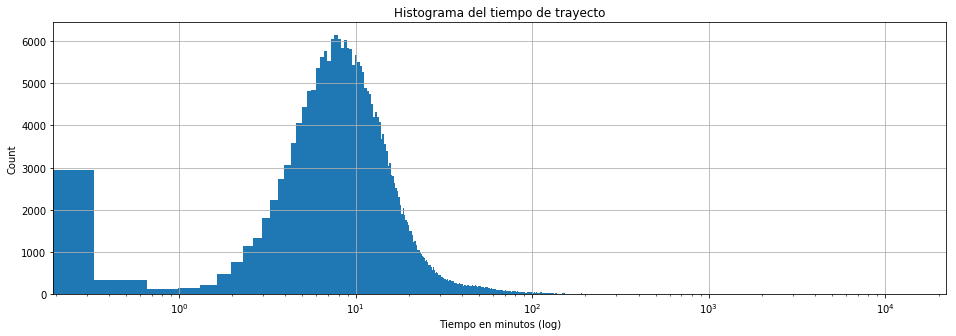

In [29]:
# /!\ Wall time: 60s
_, ax = plt.subplots(figsize=(16,5))
ax.grid()
ax.set_xscale('log')
plt.xlabel('Tiempo en minutos (log)')
plt.ylabel('Count')
plt.title(r'Histograma del tiempo de trayecto')
plt.hist(rides.travel_time/60, bins='auto')
plt.show()

In [30]:
rides['travel_time'].describe()

count    274122.000000
mean       1172.197438
std        4438.376339
min           0.000000
25%         458.000000
50%         699.000000
75%        1100.000000
max      780734.000000
Name: travel_time, dtype: float64

In [31]:
len(rides[rides['travel_time']<60])

3397

In [32]:
rides[rides['travel_time']<60].groupby('user_type')['_id'].count()

user_type
1      21
2       0
3    3376
Name: _id, dtype: int64

Hay más de 3000 trayectos con una duración de **menos de 1 minuto** y prácticamente todos son trayectos "técnicos" de BiciMAD. Los veremos y eliminaremos más adelante.

In [33]:
len(rides[rides['travel_time']>10800])

1169

Hay más de 1169 trayectos con una duración de **más de 3 horas**. Algunos podrían ser reales, aunque raros, otros no tienen ningún sentido. Los eliminaremos antes de hacer el clustering.

### Export de los datos
Para continuar en la siguiente etapa...

In [34]:
# /!\ Wall time: 52s
rides.to_json('data/Clean_201808_Usage_Bicimad.json', orient='records', date_format='iso', lines=True)